<a href="https://colab.research.google.com/github/aaronkr-classroom/14-computer-vision-pm-silluan/blob/main/14_deep_computer_vision_with_cnns_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**14장 – 합성곱 신경망을 사용한 컴퓨터 비전**

_이 노트북에는 14장의 모든 샘플 코드와 연습 문제에 대한 솔루션이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/14_deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 Scikit-Learn ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

그리고 TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

이전 챕터에서 했던 것처럼 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


이 챕터는 GPU가 없으면 매우 느려질 수 있으므로 GPU가 있는지 확인하고 그렇지 않으면 경고를 표시합니다:

In [5]:
# 이 노트북이 Colab에서 실행되고 있나요?
IS_COLAB = "google.colab" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경으로 이동하여 GPU를 선택하세요.")

# 합성곱 층
## 케라스로 합성곱 층 구현하기

두 개의 샘플 이미지를 로드하고, 픽셀 값을 0-1로 조정하고, 중앙 부분을 잘라 70×120 크기의 이미지를 만들어 보겠습니다:

In [6]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [7]:
images.shape

TensorShape([2, 70, 120, 3])

In [8]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [9]:
fmaps.shape

TensorShape([2, 64, 114, 32])

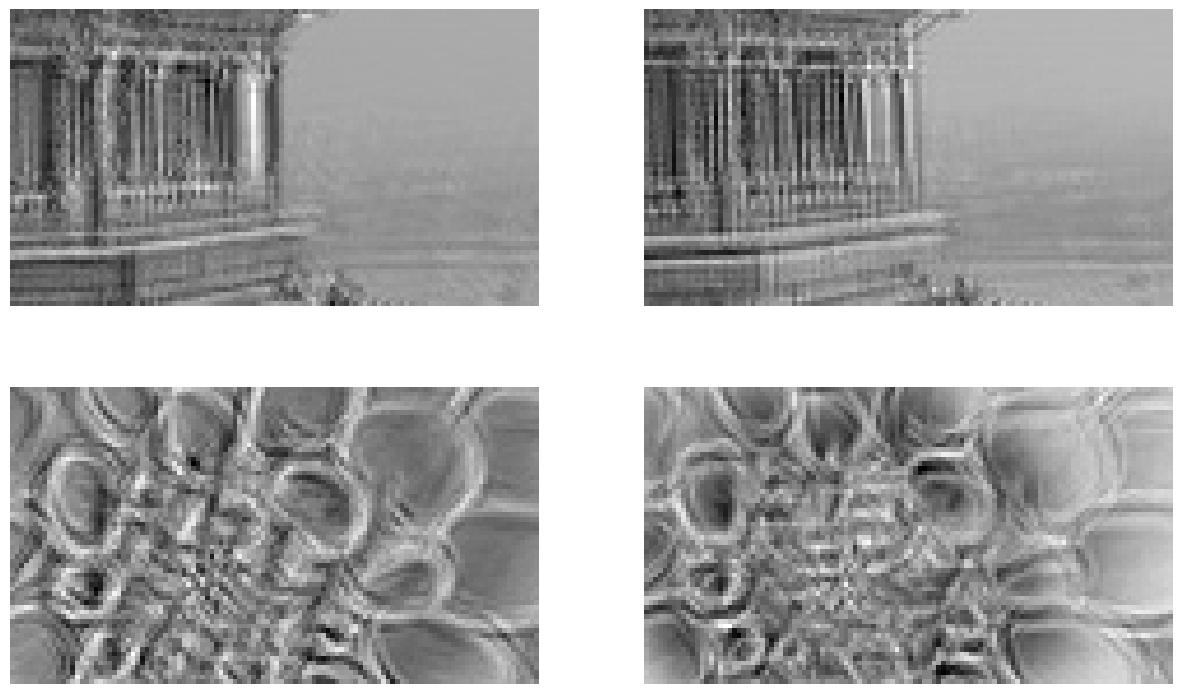

In [10]:
# 추가 코드 - 각 이미지에 대해 두 개의 출력 특성 맵을 표시합니다.

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

보시다시피 무작위로 생성된 필터는 일반적으로 엣지 감지기와 같은 역할을 하는데, 이는 이미지 처리에서 유용하며 합성곱 층은 일반적으로 이런 필터로 시작합니다. 그런 다음 훈련 중에 점차적으로 개선된 필터를 학습하여 작업에 유용한 패턴을 인식합니다.

이제 제로 패딩을 사용해 보겠습니다:

In [11]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [12]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [13]:
# 추가 코드 - strides=2로 설정했을 때의 출력 크기를 보여줍니다.
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [14]:
# 추가 코드 - 이 유틸리티 함수는 합성곱 층에서 출력되는 특성 맵의 크기를 계산합니다.
# 패딩이 "valid"인 경우 무시된 행 또는 열의 수를 반환하고, 패딩이
# "same"인 경우 제로 패딩된 행 또는 열의 수를 반환합니다.

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

이제 가중치를 살펴봅시다:

In [15]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [16]:
biases.shape

(32,)

In [17]:
# 추가 코드 - tf.nn.conv2d() 연산 사용 방법을 보여줍니다.

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

그림 14-5에서와 같이 첫 번째 필터에는 1의 수직선을, 두 번째 필터에는 1의 수평선을 제외하고 0으로 가득 찬 두 개의 필터를 수동으로 생성해 보겠습니다. 두 출력 특성 맵은 각각 수직선과 수평선을 강조 표시합니다. 합성곱 층이 필터를 자동으로 학습하므로 실제로는 필터를 수동으로 만들 필요가 없을 것입니다.

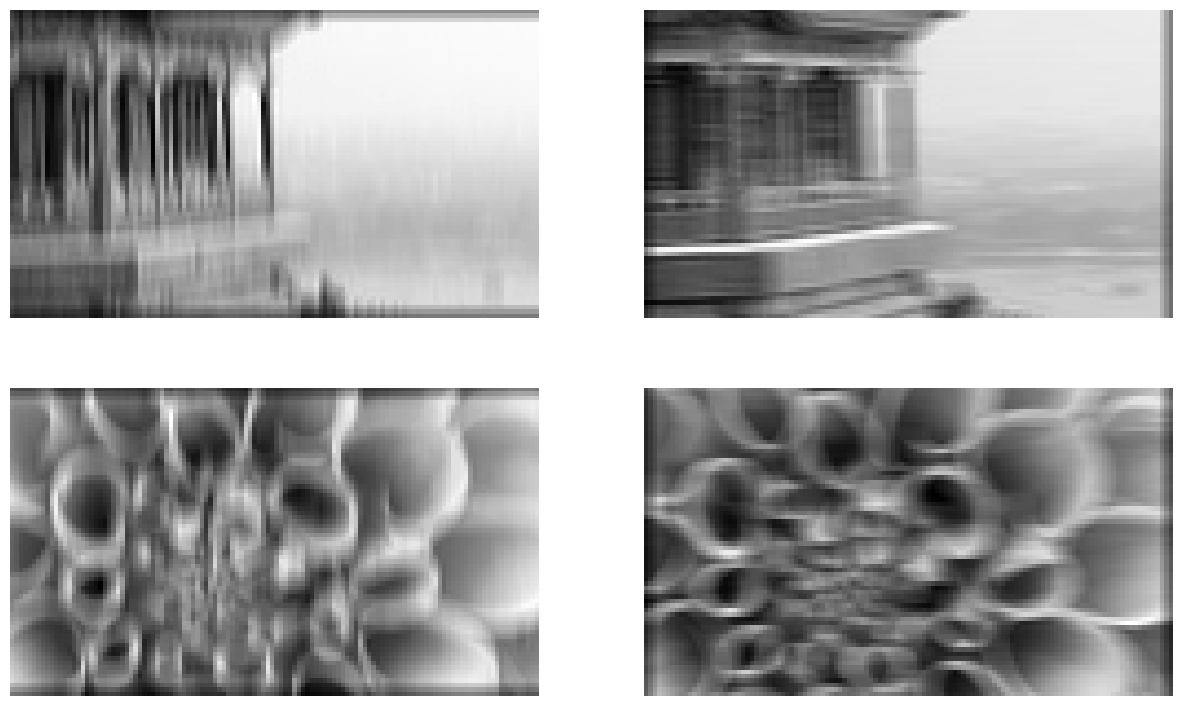

In [18]:
# 추가 코드 - 그림 14-5와 유사한 이미지를 얻기 위해 두 개의 필터를 수동으로 생성하는 방법을 보여줍니다.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

왼쪽에 있는 두 이미지의 상단과 하단, 오른쪽에 있는 두 이미지의 왼쪽과 오른쪽에 있는 어두운 선이 보이시나요? 이것이 무엇인지 짐작할 수 있나요? 이전 그림에는 왜 없었을까요?

짐작하셨죠? 이전 그림에서는 피처 맵을 만들 때 제로 패딩을 사용하지 않은 반면, 이 경우에는 제로 패딩을 사용했기 때문에 생긴 아티팩트입니다. 패딩이 0이기 때문에 수직선 필터를 기반으로 하는 두 개의 특성 맵(즉, 왼쪽 이미지 두 개)이 이미지의 상단과 하단 근처에서 완전히 활성화되지 못했습니다. 마찬가지로 수평선 필터를 기반으로 하는 두 개의 특성 맵(즉, 오른쪽 이미지 두 개)은 이미지의 왼쪽과 오른쪽 근처에서 완전히 활성화되지 못했습니다.

# 풀링
## 케라스로 풀링 층 구현하기

**최대 풀링**

In [19]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [20]:
output = max_pool(images)

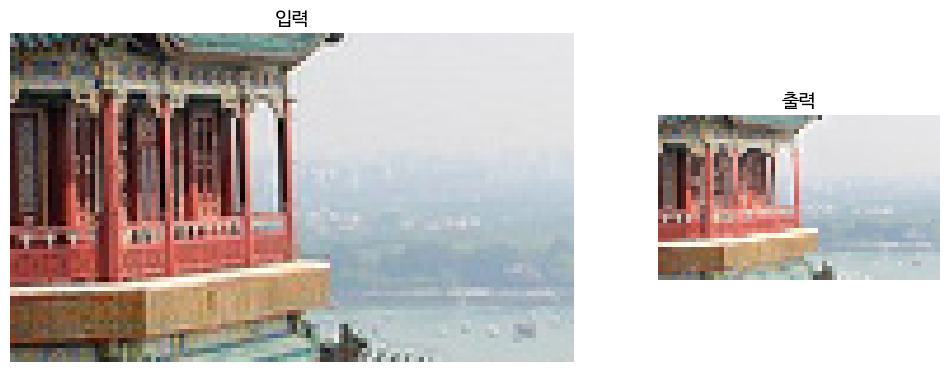

In [21]:
# 추가 코드 - 이 셀은 stride = 2인 최대 풀링이 어떻게 보이는지 보여줍니다.

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("입력")
ax1.imshow(images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("출력")
ax2.imshow(output[0])  # 첫 번째 이미지의 출력을 그립니다.
ax2.axis("off")
plt.show()

**깊이별 풀링**

In [22]:
# 추가 코드 - max_pool() 연산자를 사용하는 방법을 보여줍니다. 이 연산은 CPU에서만 동작합니다.
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [23]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1]는 채널 개수입니다.
        groups = shape[-1] // self.pool_size  # 채널 그룹 수
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [24]:
# 추가 코드 - 이 사용자 정의 층이 max_pool()과 동일한 결과를 제공함을 보여줍니다.
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

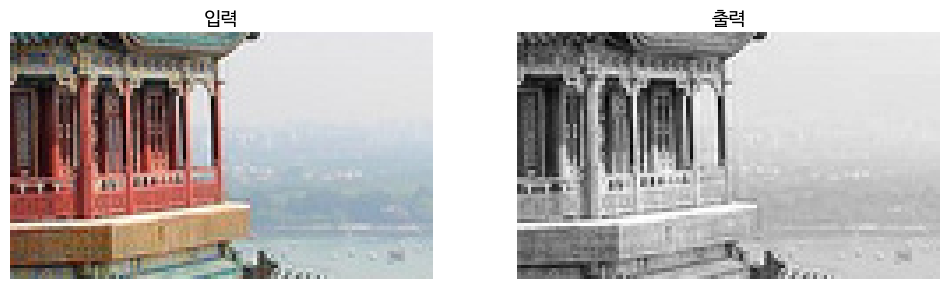

In [25]:
# 추가 코드 - 깊이별 풀링 층의 출력을 계산하고 표시합니다.

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("입력")
plt.imshow(images[0])  # 첫 번째 이미지를 그립니다.
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("출력")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # 첫 번째 이미지의 출력을 그립니다.
plt.axis("off")
plt.show()

**전역 평균 풀링**

In [26]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

다음 층과 동일합니다:

In [27]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [28]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

# CNN 구조

**CNN으로 패션 MNIST 문제 도전하기**

In [29]:
# 추가 코드 - mnist 데이터 세트를 로드하고 입력에 채널 축을 추가합니다,
#          값을 0-1 범위로 스케일링하고 데이터셋을 분할합니다.
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [30]:
from functools import partial

tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# 추가 코드 - 모델을 컴파일, 훈련, 평가하고 예측을 만듭니다.
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # 새 이미지가 있다고 가정합니다.
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.5797 - loss: 1.1835 - val_accuracy: 0.8558 - val_loss: 0.4096
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.8419 - loss: 0.4683 - val_accuracy: 0.8840 - val_loss: 0.3251
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8711 - loss: 0.3838 - val_accuracy: 0.8914 - val_loss: 0.2954
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8874 - loss: 0.3359 - val_accuracy: 0.8996 - val_loss: 0.2918
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8977 - loss: 0.3079 - val_accuracy: 0.9062 - val_loss: 0.2709
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9046 - loss: 0.2862 - val_accuracy: 0.9048 - val_loss: 0.2922
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9084 - loss: 0.2712 - val_accuracy: 0.9040 - val_loss: 0.2967
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9140 - loss: 

## LeNet-5

유명한 LeNet-5 아키텍처는 다음과 같은 층으로 구성되어 있습니다:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

여기저기서 몇 가지 조정이 있었지만 더 이상 크게 중요하지 않지만 관심이 있으신 분들을 위해 다음에 정리합니다:

* MNIST 이미지는 28×28픽셀이지만 네트워크에 주입되기 전에 32×32 픽셀로 제로 패딩되고 정규화됩니다. 네트워크의 나머지 부분에서는 패딩을 사용하지 않으므로 이미지가 네트워크를 통과할수록 크기가 계속 줄어듭니다.
* 평균 풀링 층은 일반적인 경우보다 약간 더 복잡합니다: 각 뉴런은 입력의 평균을 계산한 다음 결과에 학습 가능한 계수(맵당 하나)를 곱하고 학습 가능한 편향 항(다시 맵당 하나)을 추가한 다음 마지막으로 활성화 함수를 적용합니다.
* C3 맵의 뉴런은 대부분 (S2의 6개 맵 모두가 아니라) S2의 서너 개 맵에 있는 뉴런과만 연결되어 있습니다. 자세한 내용은 [원본 논문](https://homl.info/lenet5)의 표 1(8페이지)을 참조하세요.
* 출력 레이어는 약간 특별합니다: 입력과 가중치 벡터의 행렬 곱셈을 계산하는 대신 각 뉴런이 입력 벡터와 가중치 벡터 사이의 유클리드 거리의 제곱을 출력합니다. 각 출력은 이미지가 특정 숫자 클래스에 속하는 정도를 측정합니다. 요즘은 크로스 엔트로피 비용 함수가 더 큰 그레이디언트를 생성하고 더 빠르게 수렴하며 잘못된 예측에 훨씬 더 많은 불이익을 주기 때문에 선호됩니다.

# 케라스로 ResNet-34 CNN 구현하기

In [33]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [34]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

# 케라스에서 제공하는 사전 훈련된 모델 사용하기

In [35]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [36]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

AttributeError: Exception encountered when calling Resizing.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Resizing.call():
  • inputs=['tf.Tensor(shape=(427, 640, 3), dtype=uint8)', 'tf.Tensor(shape=(427, 640, 3), dtype=uint8)']

In [ ]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [ ]:
Y_proba = model.predict(inputs)
Y_proba.shape

In [ ]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"이미지 #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 [==============================] - 0s 0us/step
이미지 #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
이미지 #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


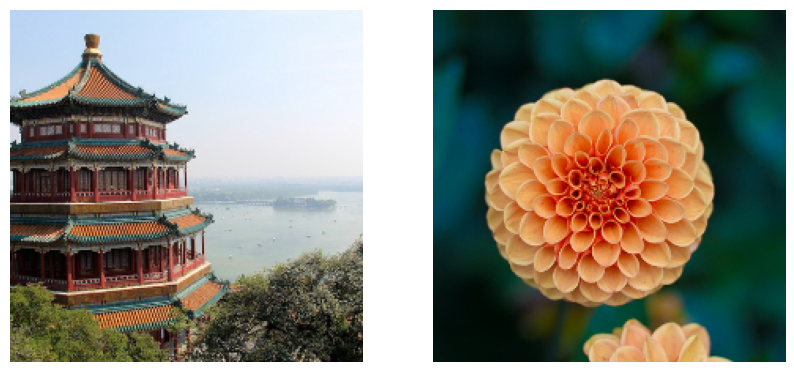

In [ ]:
# 추가 코드 - 자른 이미지와 크기 조정된 이미지를 표시합니다.

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

# 사전훈련된 모델을 사용한 전이 학습

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
dataset_size

3670

In [ ]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes

5

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

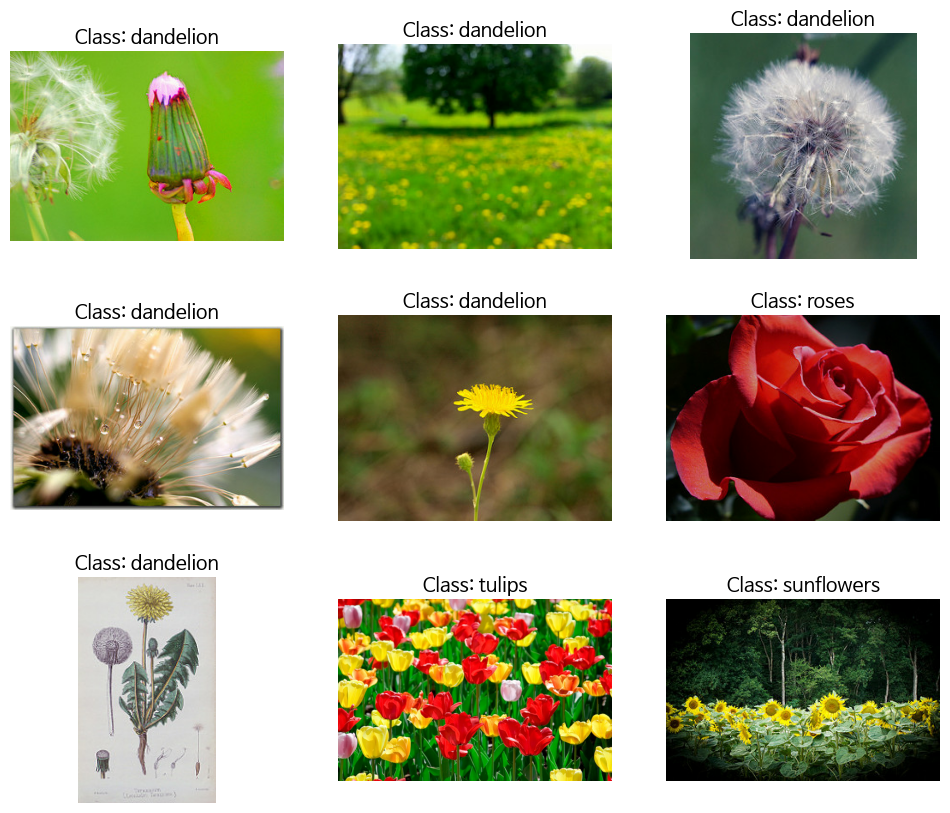

In [ ]:
# 추가 코드 - 검증 세트의 처음 9개 이미지를 표시합니다.

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

세 데이터셋 모두 이미지를 낱개로 포함하고 있습니다. 이를 배치로 묶어야 하지만 먼저 이미지 크기가 모두 동일한지 확인하겠습니다. 그렇지 않으면 배치로 묶을 수 없습니다. 이를 위해 `Resizing` 층을 사용할 수 있습니다. 또한 Xception 모델에 맞도록 이미지를 전처리하기 위해 `tf.keras.applications.xcep⁠tion.preprocess_input()` 함수를 호출해야 합니다. 마지막으로 훈련 세트를 섞고 프리페칭하겠습니다.

In [ ]:
tf.keras.backend.clear_session()  # 추가 코드 - 층 이름 카운터 재설정

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

검증 세트의 처음 9개 이미지를 다시 살펴 보겠습니다. 이제 모두 224x224이며 값은 -1에서 1 사이입니다:

In [32]:
# 추가 코드 - valid_set의 첫 번째 배치에 처음 9개의 이미지를 표시합니다.

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # imshow()를 위해 0-1로 조정합니다.
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

NameError: name 'valid_set' is not defined

<Figure size 1200x1200 with 0 Axes>

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

다음 셀을 여러 번 실행하여 다양한 무작위 데이터 증식을 확인해 보세요:

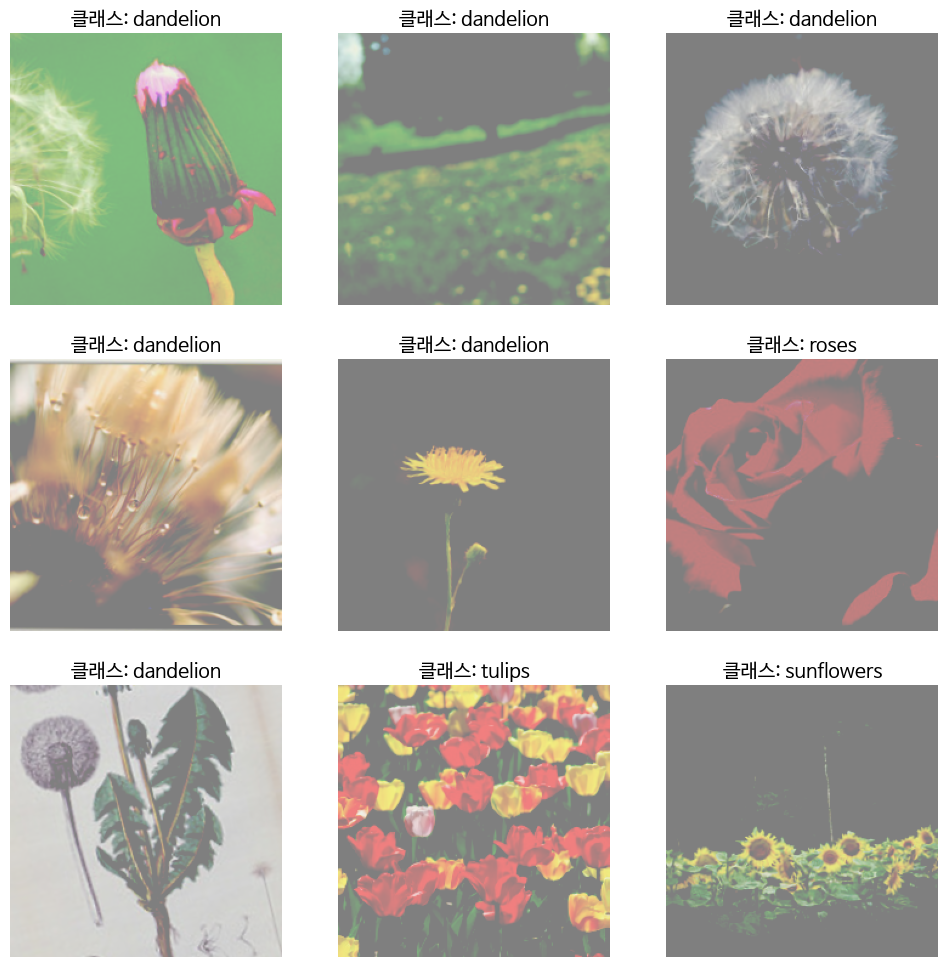

In [ ]:
# 추가 코드 - 증식 후 처음 9개의 이미지를 동일하게 표시합니다.

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # imshow()를 위해 이미지 크기를 0-1 범위로 조정합니다.
        # 데이터 증식으로 인해 일부 값이 범위를 벗어날 수 있으므로
        # (예: 이 경우 RandomContrast) 결과를 해당 범위로 클리핑합니다.
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"클래스: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

이제 최상위 층이 없는 사전 훈련된 모델을 로드하고 꽃 분류 작업을 위한 층을 그 위에 추가해 보겠습니다:

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

기반 모델의 가중치를 고정한 상태로 유지하면서 몇 개의 에포크에 대해 모델을 훈련해 보겠습니다:

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 27s 214ms/step - loss: 0.7232 - accuracy: 0.8096 - val_loss: 0.6924 - val_accuracy: 0.8312
Epoch 2/3
86/86 [==============================] - 16s 179ms/step - loss: 0.3131 - accuracy: 0.9102 - val_loss: 0.6305 - val_accuracy: 0.8348
Epoch 3/3
86/86 [==============================] - 16s 174ms/step - loss: 0.1901 - accuracy: 0.9368 - val_loss: 0.6856 - val_accuracy: 0.8494


In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

이제 새로운 최상위 층의 가중치가 나쁘지 않으므로 기반 모델의 최상위 부분을 다시 훈련할 수 있게 만들고 학습 속도를 낮추어 훈련을 계속할 수 있습니다:

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 38s 327ms/step - loss: 0.3068 - accuracy: 0.9044 - val_loss: 0.4297 - val_accuracy: 0.8784
Epoch 2/10
86/86 [==============================] - 29s 324ms/step - loss: 0.0386 - accuracy: 0.9880 - val_loss: 0.3428 - val_accuracy: 0.9020
Epoch 3/10
86/86 [==============================] - 28s 319ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.3427 - val_accuracy: 0.9038
Epoch 4/10
86/86 [==============================] - 29s 322ms/step - loss: 0.0110 - accuracy: 0.9978 - val_loss: 0.3637 - val_accuracy: 0.8984
Epoch 5/10
86/86 [==============================] - 28s 318ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.3882 - val_accuracy: 0.8947
Epoch 6/10
86/86 [==============================] - 28s 318ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.4163 - val_accuracy: 0.8911
Epoch 7/10
86/86 [==============================] - 31s 353ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.4061 - val_accuracy: 0.8984

# 분류와 위치 추정

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
# Xception 모델의 가중치 업데이트 오류를 피하기 위해
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # 중요하게 생각하는 것이 무엇인지에 따라 다릅니다.
              optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# 추가 코드 - 임의의 타깃 바운딩 박스를 사용하여 모델을 훈련합니다
# (실제에서는 대신 적절한 타깃을 생성해야 함).

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 16s 571ms/step - loss: 1.2145 - dense_1_loss: 1.4369 - dense_2_loss: 0.3251 - dense_1_accuracy: 0.4563 - dense_2_accuracy: 0.2375
Epoch 2/2
10/10 [==============================] - 6s 534ms/step - loss: 0.8140 - dense_1_loss: 0.9628 - dense_2_loss: 0.2190 - dense_1_accuracy: 0.7031 - dense_2_accuracy: 0.2844


# 추가 자료 – mAP와 정밀도/재현율 사이의 관계

In [ ]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

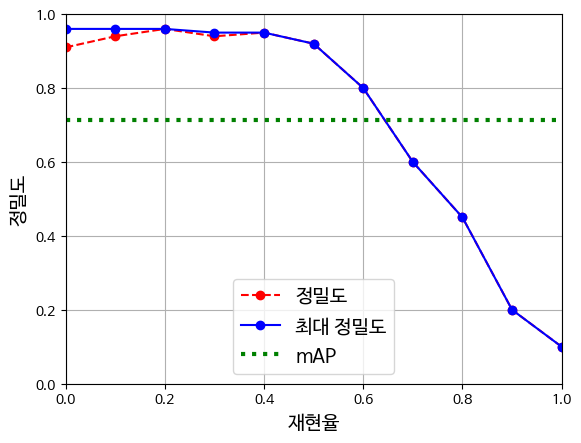

In [ ]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="정밀도")
plt.plot(recalls, max_precisions, "bo-", label="최대 정밀도")
plt.xlabel("재현율")
plt.ylabel("정밀도")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()

# 연습 문제

## 1. to 8.

부록 A 참고.

## 9. MNIST에서 높은 정확도를 내는 CNN 만들기
_연습문제: 자신만의 CNN을 만들고 MNIST 데이터셋에서 가능한 최대 정확도를 달성해보세요._

다음 모델은 2개의 합성곱 층과 1개의 풀링 층을 사용합니다. 그다음 25% 드롭아웃하고 이어서 밀집 층을 놓고 50% 드롭아웃을 다시 적용합니다. 마지막에 출력층을 놓습니다. 이 모델은 테스트 세트에서 약 99.2% 정확도를 냅니다. 이 모델은 [MNIST 캐글 경연대회](https://www.kaggle.com/c/digit-recognizer/)에서 상위 20위 안에 포함되는 수준입니다(Chris Deotte가 [이 포스트](https://www.kaggle.com/c/digit-recognizer/discussion/61480)에서 설명했듯이 테스트 세트에서 훈련된 것 같은 99.79%보다 높은 정확도를 가진 모델은 무시합니다). 더 높일 수 있을까요? 테스트 세트에서 99.5~99.7% 사이의 정확도를 달성하려면 이미지 증식, 배치 정규화를 추가하고 1-cycle 같은 학습률 스케줄을 사용하고 앙상블 모델을 만들어야 합니다.

In [ ]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 14s 6ms/step - loss: 0.2067 - accuracy: 0.9375 - val_loss: 0.0422 - val_accuracy: 0.9886
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0844 - accuracy: 0.9749 - val_loss: 0.0383 - val_accuracy: 0.9894
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0624 - accuracy: 0.9807 - val_loss: 0.0360 - val_accuracy: 0.9912
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0486 - accuracy: 0.9848 - val_loss: 0.0351 - val_accuracy: 0.9918
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0415 - accuracy: 0.9874 - val_loss: 0.0361 - val_accuracy: 0.9912
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0370 - accuracy: 0.9889 - val_loss: 0.0314 - val_accuracy: 0.9914
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0304 - accuracy: 0.9903 - val_loss: 0.0328 - val_ac

[0.03312002494931221, 0.991100013256073]

## 10. 전이 학습을 사용한 대규모 이미지 분류

_연습문제: 다음 단계를 따라 전이 학습을 사용해 대규모 이미지 분류를 수행해보세요:_

* _클래스마다 최소한 100개의 이미지가 들어 있는 훈련 세트를 만드세요. 예를 들어 위치에 따라(해변, 산, 도심 등) 자신의 사진을 분류하거나, 기존의 데이터셋(예를 들면, 텐서플로 데이터셋)을 사용할 수도 있습니다._
* _이를 훈련 세트와 검증 세트, 테스트 세트로 나눕니다._
* _적절한 전처리 연산과 선택적으로 데이터 증식을 수행하는 입력 파이프라인을 만듭니다._
* _이 데이터셋에서 사전훈련된 모델을 미세 튜닝합니다._

Flowers 예제를 참고하세요.

## 11.
_연습문제: 텐서플로의 [스타일 전이 튜토리얼](https://homl.info/styletuto)을 살펴보세요. 딥러닝을 사용해 재미있는 그림을 생성할 수 있습니다._

코랩을 사용해 튜토리얼을 따라해 보세요.